# Fit Demo - NGC 337
------------------------------
Using the Dale et al. (2017) photometry, fit the SED of NGC 337 with a basic model.

## Imports

In [1]:
import numpy as np
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## NGC 337
Used in the ["basic" example in the Lightning documentation](https://lightning-sed.readthedocs.io/en/latest/examples/NGC_337_example.html). Compare all the plots.

In [2]:
cat = Table.read('example_photometry/ngc337_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

l = Lightning(filter_labels, 
              lum_dist=dl, 
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              print_setup_time=True)

l.flux_obs = fnu_obs * 1e3
# No model uncertainty implemented yet, though that will be trivial to add
flux_unc_total = np.sqrt(fnu_unc**2 + (0.10 * fnu_obs)**2) 
l.flux_unc = flux_unc_total * 1e3

/Users/Erik/Documents/Research/lightning/plightning/lightning/get_filters.py:61: RuntimeWarning: invalid value encountered in true_divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


0.180 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.705 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
2.268 s elapsed in dust emission model setup
3.154 s elapsed total


### Fit with `emcee`

In [3]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, False, True,
                      True, False, True, False, False])

# This is a little tedious 
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]),
          UniformPrior([0.0047, 0.0458])]

var_dim = ~const_dim

# Starting the MCMC in a very small Gaussian ball around the above parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(75, len(p)))
p0[:, const_dim] = p[const_dim]

In [4]:
# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0, method='emcee', Nwalkers=75, Nsteps=5000, priors=priors, const_dim=const_dim)

100%|██████████| 5000/5000 [09:00<00:00,  9.25it/s]


In [5]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
# print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean acceptance fraction: 0.328


In [6]:
# We'll thin by a factor that's overkill since our estimate of the autocorrelation time
# may be wrong
chain = mcmc.get_chain(discard=1000, thin=300, flat=True)
logprob_chain = mcmc.get_log_prob(discard=1000, thin=300, flat=True)

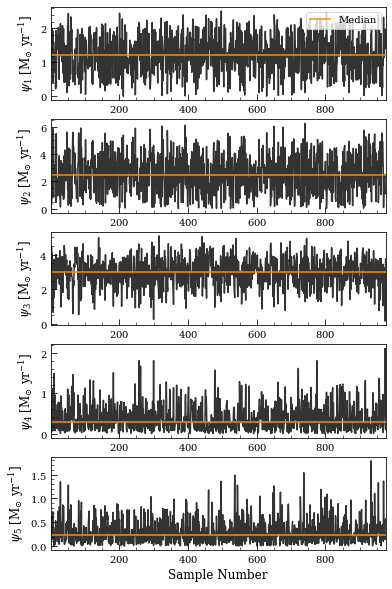

In [7]:
fig, axs = plt.subplots(5,1, figsize=(6,10))

t = np.arange(len(chain[:,0])) + 1
for i in np.arange(5):
    axs[i].plot(t, chain[:,i], color='k', alpha=0.8)
    axs[i].axhline(np.median(chain[:,i]), color='darkorange', label='Median')
    #axs[i].axhline(1, color='dodgerblue', label='Truth')
    axs[i].set_ylabel(r'$\psi_%d\ [\rm M_{\odot}\ yr^{-1}]$' % (i + 1))
    axs[i].set_xlim(1,t[-1])
    #axs[i].set_yscale('log')

axs[4].set_xlabel('Sample Number')

axs[0].legend(loc='upper right', frameon=True)

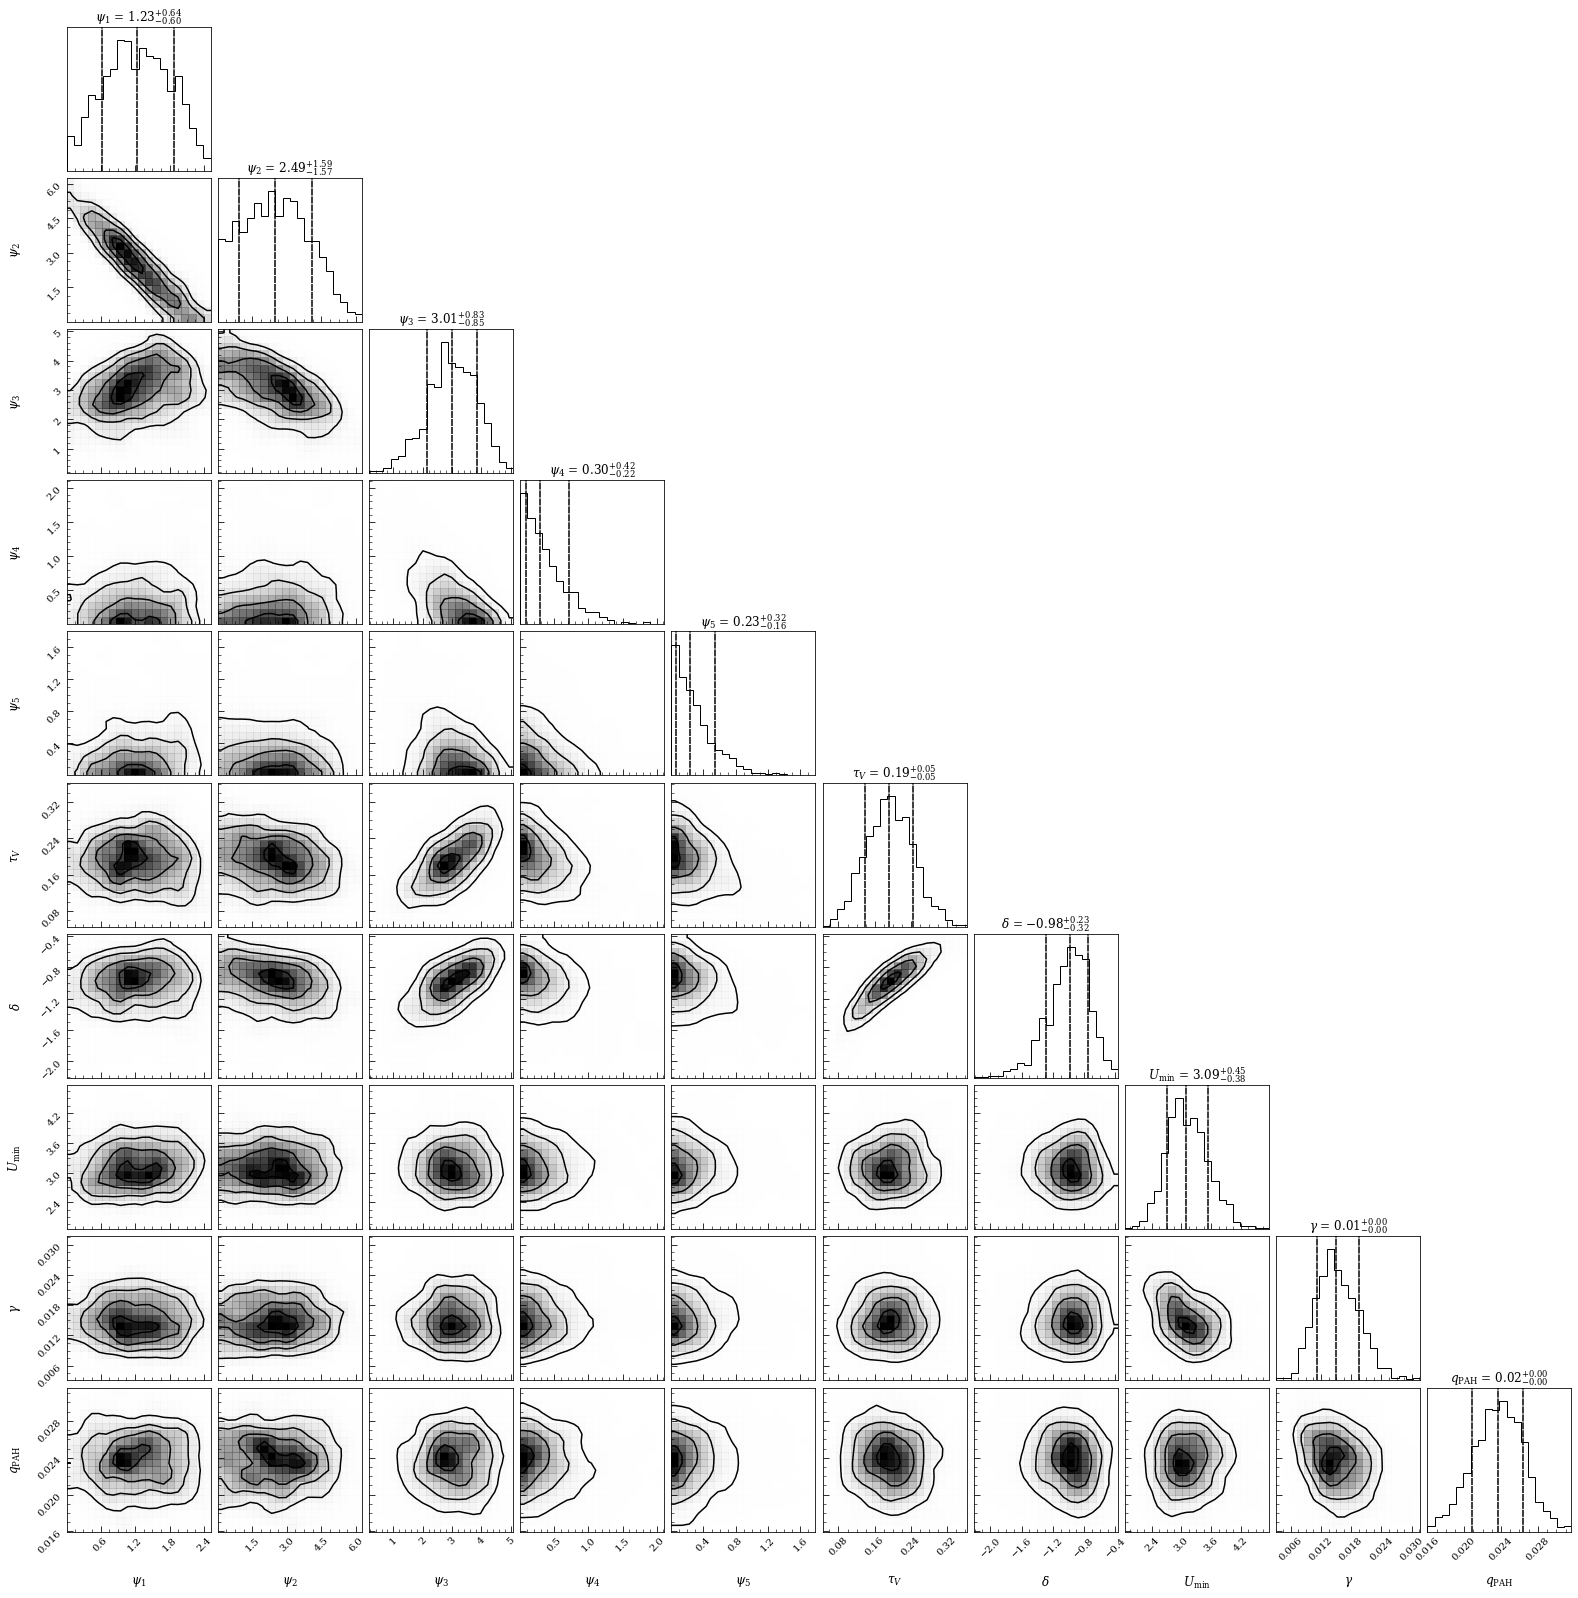

In [8]:
labels = [r'$\psi_1$', r'$\psi_2$', r'$\psi_3$', r'$\psi_4$', r'$\psi_5$',
          r'$\tau_V$', r'$\delta$', r'$U_{\rm min}$', r'$\gamma$', r'$q_{\rm PAH}$']

fig = corner(chain, labels=labels, quantiles=(0.16, 0.50, 0.84), smooth=1, show_titles=True)

In [9]:
# Get best-fitting SED
bestfit = np.argmax(logprob_chain)
bestfit_samples = chain[bestfit,:]
bestfit_params = p
bestfit_params[var_dim] = bestfit_samples

lnu_hires_best, lnu_hires_intr_best = l.get_model_lnu_hires(bestfit_params)
lnu_best, lnu_intr_best = l.get_model_lnu(bestfit_params)

# Get the quantiles of the SFH
sfh_q = np.quantile(chain[:,:5], q=(0.16, 0.5, 0.84), axis=0)

(1000000.0, 13600000000.0)

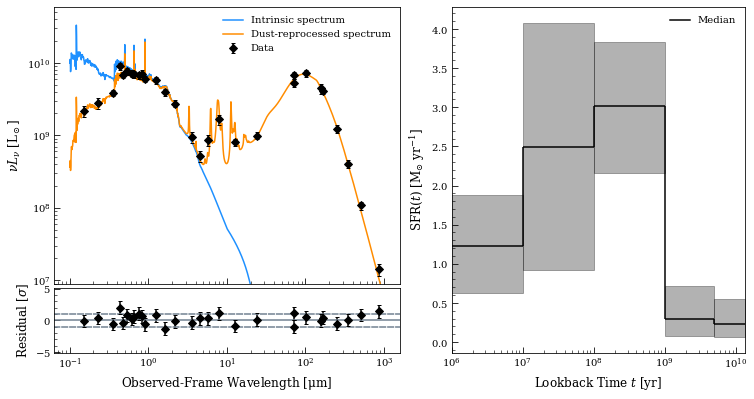

In [10]:
# fig, axs = plt.subplots(1,2, figsize=(12,6))
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1, 0.26, 0.4, 0.64])
ax2 = fig.add_axes([0.1, 0.1, 0.4, 0.15])
ax3 = fig.add_axes([0.56, 0.1, 0.34, 0.8])

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_intr_best,
            color='dodgerblue', label='Intrinsic spectrum')

ax1.plot(l.wave_grid_obs, l.nu_grid_obs * lnu_hires_best,
            color='darkorange', label='Dust-reprocessed spectrum')

ax1.errorbar(l.wave_obs, l.nu_obs * l.Lnu_obs, yerr=l.nu_obs * l.Lnu_unc,
                marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='',
                label='Data')

#ax1.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax1.set_ylabel(r'$\nu L_{\nu}\ [\rm L_\odot]$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(0.9 * 1e7,)
ax1.legend(loc='upper right')

delchi = (l.Lnu_obs - lnu_best) / l.Lnu_unc

ax2.axhline(0, color='slategray', linestyle='-')
ax2.axhline(-1, color='slategray', linestyle='--')
ax2.axhline(1, color='slategray', linestyle='--')

ax2.errorbar(l.wave_obs, delchi, yerr=(1 + np.zeros_like(delchi)),
             marker='D', color='k', markerfacecolor='k', capsize=2, linestyle='')

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(-5.1,5.1)

ax2.set_xlabel(r'Observed-Frame Wavelength $[\rm \mu m]$')
ax2.set_ylabel(r'Residual $[\sigma]$')

# Making nice step plots remains an annoyance
#print(sfh_q.shape)
for i in np.arange(len(l.ages) - 1):
    ax3.fill_between([l.ages[i], l.ages[i+1]],
                        [sfh_q[0,i], sfh_q[0,i]], 
                        [sfh_q[2,i], sfh_q[2,i]],
                        color='k', alpha=0.3)
    l1 = ax3.hlines(sfh_q[1,i], l.ages[i], l.ages[i+1], color='k')
    if (i < len(l.ages) - 2): 
        ax3.vlines(l.ages[i+1], sfh_q[1,i], sfh_q[1,i+1], color='k')

ax3.legend([l1], ['Median'], loc='upper right')

ax3.set_xlabel(r'Lookback Time $t$ [yr]')
ax3.set_ylabel(r'${\rm SFR}(t)\ [\rm M_{\odot}\ yr^{-1}]$')
        
ax3.set_xscale('log')
ax3.set_xlim(1e6,13.6*10**9)